In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm



In [2]:
data_dir = os.path.join(os.curdir, 'bottlesandcans/')
                        
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 1075 files belonging to 8 classes.
Using 860 files for training.
Found 1075 files belonging to 8 classes.
Using 215 files for validation.


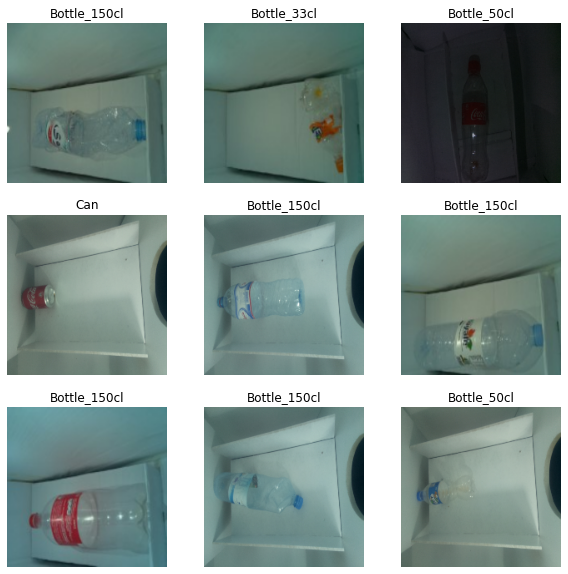

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])

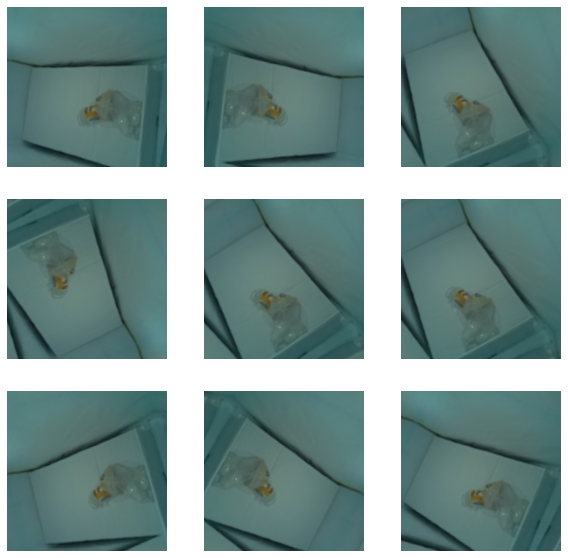

In [8]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choose Transfer Learning Model 

As a first execution of the notebook, we will use the following pre-trained model: **MobileNetV2** developed by Google (dowloaded via  `tf.keras.applications.MobileNetV2` ). This will be your base model. The big advantage is that it was trained on ImageNet data! So 1.4M images :) with a wide variety of categories like `jackfruit` and `syringe`. Not on smiles though...Will this help us in recognizing smiles??

Note: Every model was trained using specific image preprocessing requirements. YOU NEED TO CHECK EACH TIME WHAT PECULIAR OF A SPECIFIC MODEL!
Here the guide for MobileNetV2 https://keras.io/api/applications/mobilenet/.

This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. 
At best, you always use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


a. Freeze weights, use the feature extraction as it is, attach a new classification head
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

 ization)                                                                                         
                                                                                                  
 block_9_expand_relu (ReLU)     (None, 12, 12, 384)  0           ['block_9_expand_BN[0][0]']      
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, 12, 12, 384)  3456       ['block_9_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, 12, 12, 384)  1536       ['block_9_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_9_d

Let's now combine this model with a classification head, meaning some fully connected layers (tf.keras.layers.Dense).
Build a model by chaining together the data augmentation, preproccesing, base_model and classification layers (note that the syntax is slighly different, we are using the [Keras Functional API]).

Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
#x = tf.keras.layers.Dense(10, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

Above you see how many parameters you are actually training, and how many are frozen.

Train the model

In [19]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 59s 6s/step - loss: 2.1776 - accuracy: 0.1581


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.18
initial accuracy: 0.16


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
27/27 [==============================] - 103s 2s/step - loss: -0.0978 - accuracy: 0.3140 - val_loss: -0.8540 - val_accuracy: 0.3535
Epoch 2/20
27/27 [==============================] - 43s 2s/step - loss: -2.9255 - accuracy: 0.4058 - val_loss: -3.4056 - val_accuracy: 0.3721
Epoch 3/20
27/27 [==============================] - 28s 1s/step - loss: -5.1611 - accuracy: 0.4174 - val_loss: -5.7786 - val_accuracy: 0.3721
Epoch 4/20
27/27 [==============================] - 29s 1s/step - loss: -7.4808 - accuracy: 0.4174 - val_loss: -8.0664 - val_accuracy: 0.3721
Epoch 5/20
27/27 [==============================] - 28s 992ms/step - loss: -9.5190 - accuracy: 0.4174 - val_loss: -10.3351 - val_accuracy: 0.3721
Epoch 6/20
27/27 [==============================] - 26s 944ms/step - loss: -11.9004 - accuracy: 0.4174 - val_loss: -12.6110 - val_accuracy: 0.3721
Epoch 7/20
27/27 [==============================] - 26s 935ms/step - loss: -14.0431 - accuracy: 0.4174 - val_loss: -14.8586 - val_accuracy

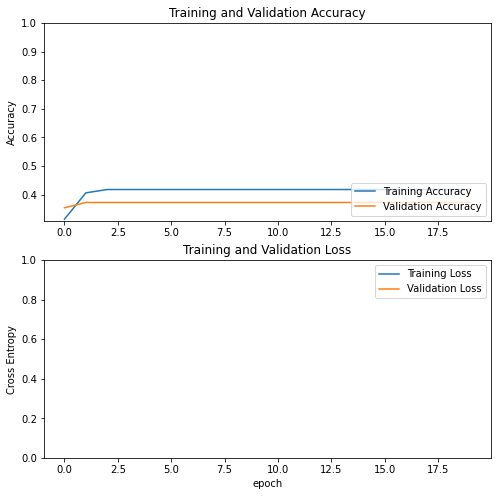

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()